In [157]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle as pkl
from matplotlib import pyplot as plt
import gc
from tqdm import tqdm

In [19]:
def reduce_mem_usage(df):
    """iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if (
                    c_min > np.finfo(np.float16).min
                    and c_max < np.finfo(np.float16).max
                ):
                    df[col] = df[col].astype(np.float16)
                elif (
                    c_min > np.finfo(np.float32).min
                    and c_max < np.finfo(np.float32).max
                ):
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024 ** 2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df

In [17]:
datadir = Path().resolve().parent / "data"
cachedir = Path().resolve().parent / "cache"

train = reduce_mem_usage(pd.read_csv(cachedir / "train_lstm-less-cut-addfeatures_debugFalse.csv"))
test = reduce_mem_usage(pd.read_csv(cachedir / "test_lstm-less-cut-addfeatures_debugFalse.csv"))

In [20]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 2216.21 MB
Memory usage after optimization is: 506.20 MB
Decreased by 77.2%
Memory usage of dataframe is 1464.04 MB
Memory usage after optimization is: 334.11 MB
Decreased by 77.2%


In [65]:
train_distances = pkl.load(open(datadir / "train_distances.pkl", "rb"))
train_neighbors = pkl.load(open(datadir / "train_neighbors.pkl", "rb"))
test_distances = pkl.load(open(datadir / "test_distances.pkl", "rb"))
test_neighbors = pkl.load(open(datadir / "test_neighbors.pkl", "rb"))

In [28]:
distances = []
for bid, dist in train_distances.items():
    distances += dist[1:]
distances = np.array(distances)

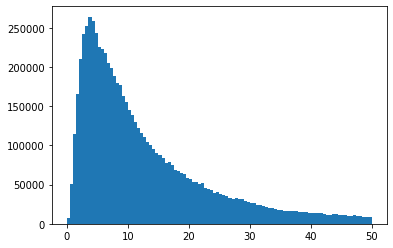

In [57]:
plt.hist(distances[distances < 50], bins=100)
plt.show()

In [117]:
u_ins = train["u_in"].values.reshape(-1, 35)
pressures = train["pressure"].values.reshape(-1, 35)

train_plain = pd.read_csv(datadir / "train_RC_kfold10_seed42.csv")
bids = train_plain.iloc[0::80]["breath_id"].values

del train_plain
gc.collect()

0

In [154]:
new_features = [
    "u_in_neib_mean_diff", "u_in_neib_median_diff", "u_in_neib_best_diff", "u_in_neib_iqr",
    "pressure_neib_mean", "pressure_neib_median", "pressure_best_neib", "pressure_neib_iqr"
]
new_features = {f: [] for f in new_features}

for bid in tqdm(bids):
    u_in_ = u_ins[bids == bid, :]
    
    neib_dist = np.array(train_distances[bid])[1:]
    neib_bids = np.array(train_neighbors[bid])[1:]
    idx_ = np.argsort(neib_bids)
    neib_dist = neib_dist[idx_]
    neib_bids = neib_bids[idx_]
    
    indices = np.isin(bids, neib_bids)
    
    neib_u_in = u_ins[indices, :]
    neib_pressure = pressures[indices, :]
    
    idx_ = np.argsort(neib_dist)
    neib_u_in = neib_u_in[idx_]
    neib_pressure = neib_pressure[idx_]
    
    nui_mean, nui_best = np.mean(neib_u_in, axis=0), neib_u_in[0, :]
    nui_q25, nui_q50, nui_q75 = np.quantile(neib_u_in, [0.25, 0.5, 0.75], axis=0)
    np_mean, np_best = np.mean(neib_pressure, axis=0), neib_pressure[0, :]
    np_q25, np_q50, np_q75 = np.quantile(neib_pressure, [0.25, 0.5, 0.75], axis=0)
    
    new_features["u_in_neib_mean_diff"].append(u_in_ - nui_mean)
    new_features["u_in_neib_median_diff"].append(u_in_ - nui_q50)
    new_features["u_in_neib_best_diff"].append(u_in_ - nui_best)
    new_features["u_in_neib_iqr"].append(nui_q75 - nui_q25)
    
    new_features["pressure_neib_mean"].append(np_mean)
    new_features["pressure_neib_median"].append(np_q50)
    new_features["pressure_best_neib"].append(np_best)
    new_features["pressure_neib_iqr"].append(np_q75 - np_q25)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 75450/75450 [04:05<00:00, 306.78it/s]


In [155]:
for f_nm, f_value in new_features.items():
    train[f_nm] = np.concatenate(f_value).reshape(-1)
    
train.to_csv(cachedir / "train-classify-rc-debugFalse.csv", index=False)
train.iloc[:1000 * 35].to_csv(cachedir / "train-classify-rc-debugTrue.csv", index=False)

In [124]:
test_u_ins = test["u_in"].values.reshape(-1, 35)

test_plain = pd.read_csv(datadir / "test.csv")
test_bids = test_plain.iloc[0::80]["breath_id"].values

del test_plain
gc.collect()

36

In [150]:
new_features = [
    "u_in_neib_mean_diff", "u_in_neib_median_diff", "u_in_neib_best_diff", "u_in_neib_iqr",
    "pressure_neib_mean", "pressure_neib_median", "pressure_best_neib", "pressure_neib_iqr"
]
new_features = {f: [] for f in new_features}

for bid in tqdm(test_bids):
    u_in_ = test_u_ins[test_bids == bid, :]
    
    neib_dist = np.array(test_distances[bid])[1:]
    neib_bids = np.array(test_neighbors[bid])[1:]
    idx_ = np.argsort(neib_bids)
    neib_dist = neib_dist[idx_]
    neib_bids = neib_bids[idx_]
    
    indices = np.isin(bids, neib_bids)
    
    neib_u_in = u_ins[indices, :]
    neib_pressure = pressures[indices, :]
    
    idx_ = np.argsort(neib_dist)
    neib_u_in = neib_u_in[idx_]
    neib_pressure = neib_pressure[idx_]
    
    nui_mean, nui_best = np.mean(neib_u_in, axis=0), neib_u_in[0, :]
    nui_q25, nui_q50, nui_q75 = np.quantile(neib_u_in, [0.25, 0.5, 0.75], axis=0)
    np_mean, np_best = np.mean(neib_pressure, axis=0), neib_pressure[0, :]
    np_q25, np_q50, np_q75 = np.quantile(neib_pressure, [0.25, 0.5, 0.75], axis=0)
    
    new_features["u_in_neib_mean_diff"].append(u_in_ - nui_mean)
    new_features["u_in_neib_median_diff"].append(u_in_ - nui_q50)
    new_features["u_in_neib_best_diff"].append(u_in_ - nui_best)
    new_features["u_in_neib_iqr"].append(nui_q75 - nui_q25)
    
    new_features["pressure_neib_mean"].append(np_mean)
    new_features["pressure_neib_median"].append(np_q50)
    new_features["pressure_best_neib"].append(np_best)
    new_features["pressure_neib_iqr"].append(np_q75 - np_q25)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50300/50300 [02:48<00:00, 298.04it/s]


In [152]:
for f_nm, f_value in new_features.items():
    test[f_nm] = np.concatenate(f_value).reshape(-1)
    
test.to_csv(cachedir / "test-classify-rc-debugFalse.csv", index=False)
test.iloc[:1000 * 35].to_csv(cachedir / "test-classify-rc-debugTrue.csv", index=False)